Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/Users/rishabh.sharma/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train/")
data_dir_test = pathlib.Path('./Test/')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 64
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

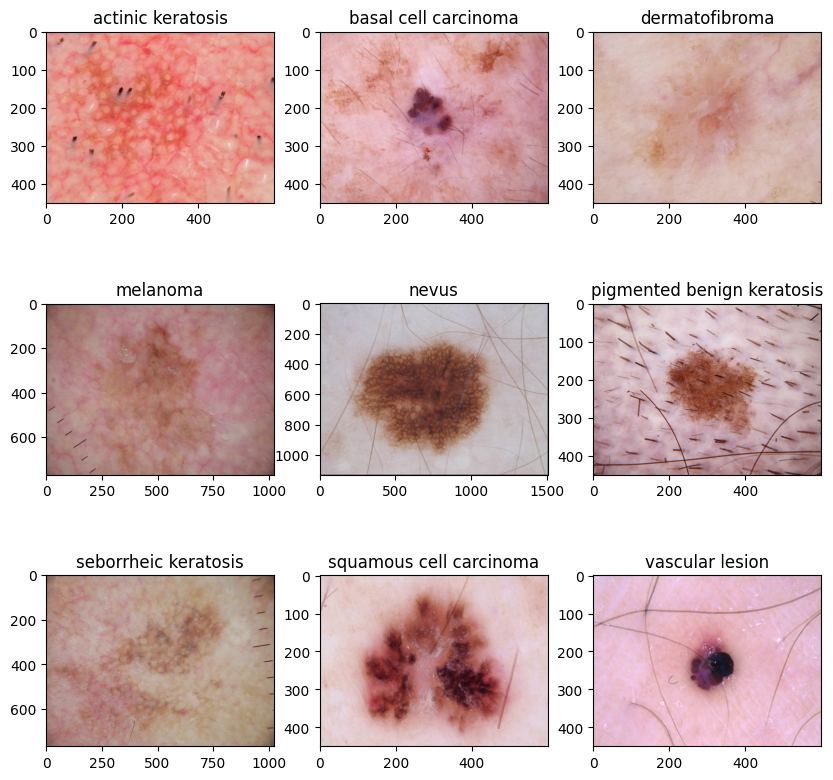

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(64, 180, 180, 3)`. This is a batch of 64 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(64,)`, these are corresponding labels to the 64 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [38]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
])
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/Users/rishabh.sharma/Library/Python/3.9/lib/python/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


28/28 [==============================] - 10s 247ms/step - loss: 2.0545 - accuracy: 0.1959 - val_loss: 2.0508 - val_accuracy: 0.2058
Epoch 2/20
28/28 [==============================] - 6s 217ms/step - loss: 2.0355 - accuracy: 0.2009 - val_loss: 2.0279 - val_accuracy: 0.2058
Epoch 3/20
28/28 [==============================] - 6s 218ms/step - loss: 1.9976 - accuracy: 0.2349 - val_loss: 2.0261 - val_accuracy: 0.2327
Epoch 4/20
28/28 [==============================] - 6s 217ms/step - loss: 1.9258 - accuracy: 0.2695 - val_loss: 2.0496 - val_accuracy: 0.1834
Epoch 5/20
28/28 [==============================] - 6s 218ms/step - loss: 1.8680 - accuracy: 0.3019 - val_loss: 1.8713 - val_accuracy: 0.3043
Epoch 6/20
28/28 [==============================] - 6s 218ms/step - loss: 1.7788 - accuracy: 0.3421 - val_loss: 1.8173 - val_accuracy: 0.3020
Epoch 7/20
28/28 [==============================] - 6s 218ms/step - loss: 1.7222 - accuracy: 0.3616 - val_loss: 1.8013 - val_accuracy: 0.3333
Epoch 8/20
28/28

### Visualizing training results

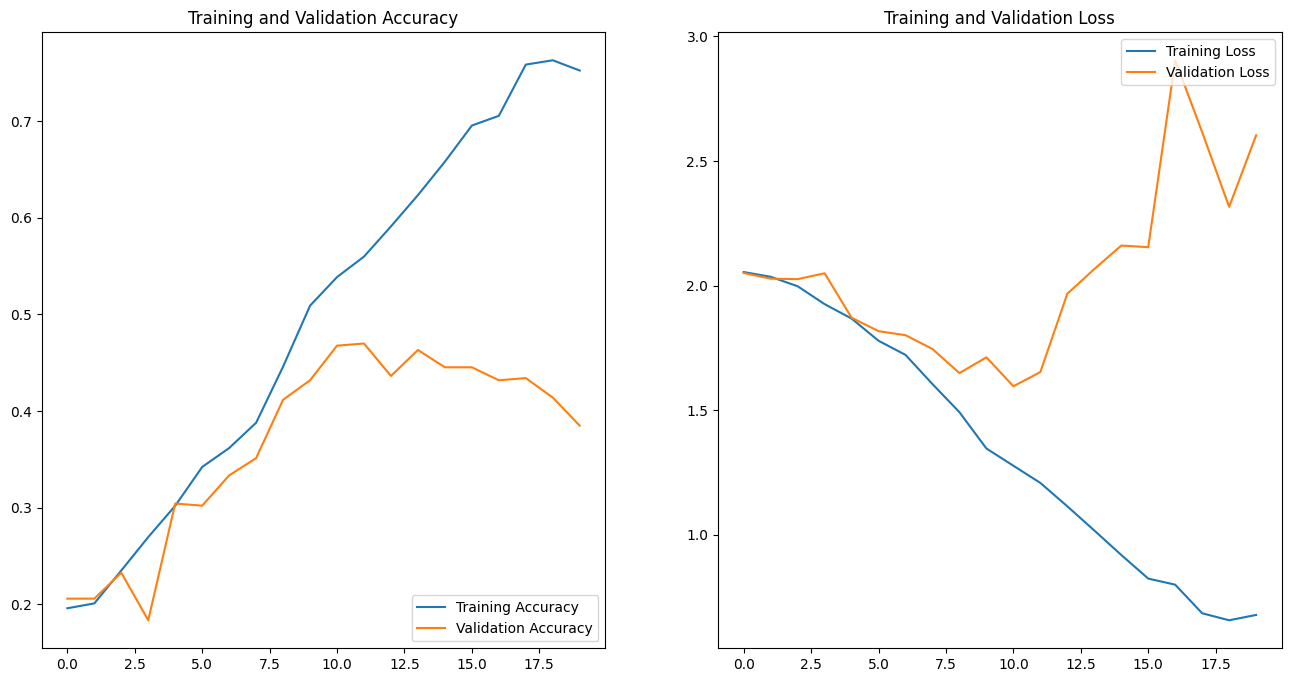

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* We can clearly see that after 10 epochs, the model starts to Overfit.
* After 10 epochs, training accuracy keeps on increasing while validation accuracy decreases, indicating an overfit.
* This can be handled using Dropout and augmenting more data.

### Write your findings here

In [11]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

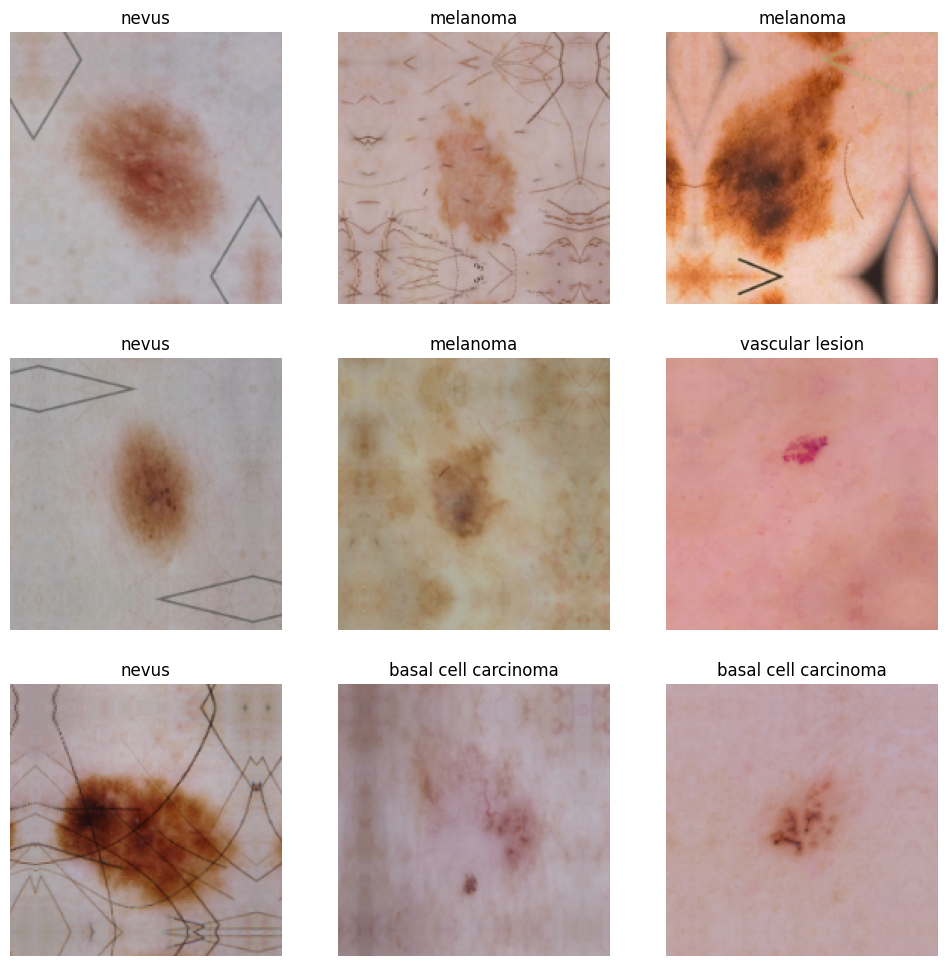

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
      
])
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.50))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


28/28 [==============================] - 8s 248ms/step - loss: 2.0923 - accuracy: 0.1881 - val_loss: 2.1581 - val_accuracy: 0.1924
Epoch 2/20
28/28 [==============================] - 7s 242ms/step - loss: 2.0242 - accuracy: 0.2137 - val_loss: 2.1280 - val_accuracy: 0.2058
Epoch 3/20
28/28 [==============================] - 7s 242ms/step - loss: 2.0056 - accuracy: 0.2249 - val_loss: 2.1302 - val_accuracy: 0.1879
Epoch 4/20
28/28 [==============================] - 7s 241ms/step - loss: 1.9831 - accuracy: 0.2400 - val_loss: 2.1464 - val_accuracy: 0.2081
Epoch 5/20
28/28 [==============================] - 7s 242ms/step - loss: 1.9593 - accuracy: 0.2651 - val_loss: 2.1323 - val_accuracy: 0.2192
Epoch 6/20
28/28 [==============================] - 7s 242ms/step - loss: 1.9460 - accuracy: 0.2511 - val_loss: 2.1432 - val_accuracy: 0.1969
Epoch 7/20
28/28 [==============================] - 7s 242ms/step - loss: 1.9036 - accuracy: 0.2656 - val_loss: 2.1453 - val_accuracy: 0.1946
Epoch 8/20
28/28 

### Visualizing the results

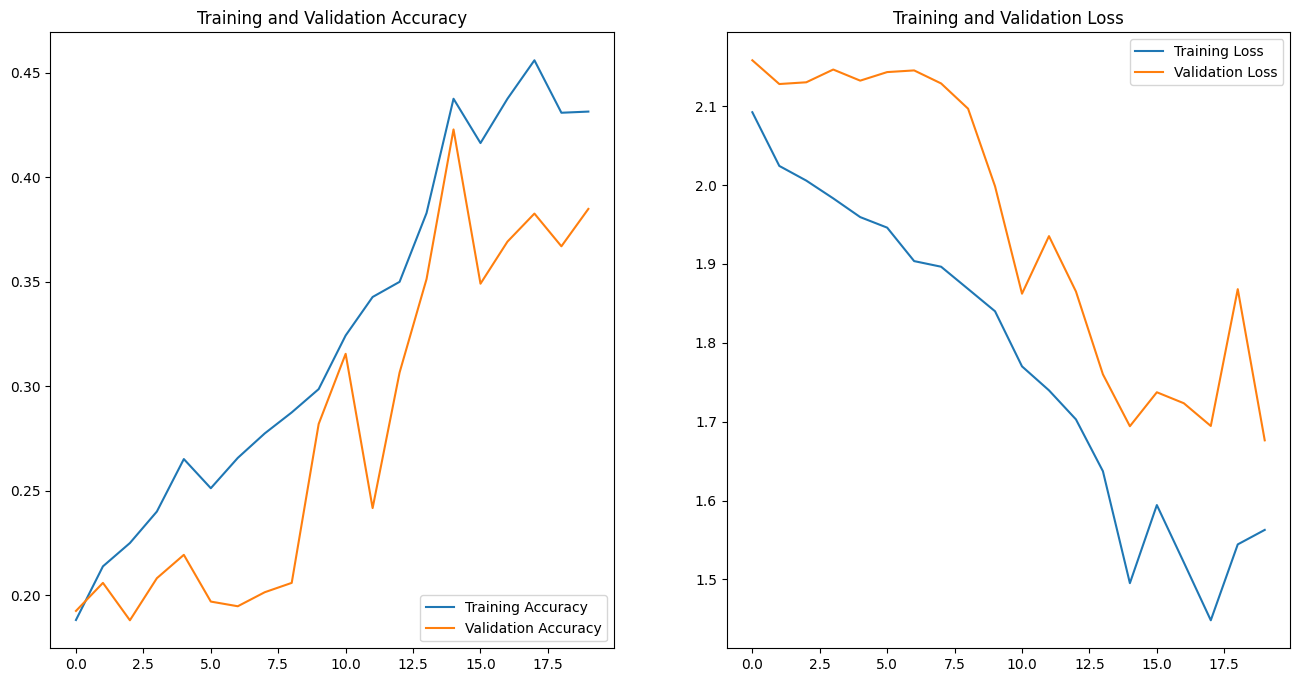

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* We can see that the model is underfitting as both training and validation accuracy are low. 
* Adding the dropout layers made the made the model too simple to learn patterns from the data.
* Training for more epochs or making the model complex might reduce the underfit.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [12]:
path_list=[]
lesion_list=[]

for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Train/actinic keratosis/ISIC_0029460.jpg,actinic keratosis
1,Train/actinic keratosis/ISIC_0031993.jpg,actinic keratosis
2,Train/actinic keratosis/ISIC_0029500.jpg,actinic keratosis
3,Train/actinic keratosis/ISIC_0026626.jpg,actinic keratosis
4,Train/actinic keratosis/ISIC_0032135.jpg,actinic keratosis
...,...,...
2234,Train/vascular lesion/ISIC_0032919.jpg,vascular lesion
2235,Train/vascular lesion/ISIC_0033031.jpg,vascular lesion
2236,Train/vascular lesion/ISIC_0031197.jpg,vascular lesion
2237,Train/vascular lesion/ISIC_0030882.jpg,vascular lesion


In [13]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Train/actinic keratosis/ISIC_0029460.jpg,actinic keratosis
1,Train/actinic keratosis/ISIC_0031993.jpg,actinic keratosis
2,Train/actinic keratosis/ISIC_0029500.jpg,actinic keratosis
3,Train/actinic keratosis/ISIC_0026626.jpg,actinic keratosis
4,Train/actinic keratosis/ISIC_0032135.jpg,actinic keratosis
...,...,...
2234,Train/vascular lesion/ISIC_0032919.jpg,vascular lesion
2235,Train/vascular lesion/ISIC_0033031.jpg,vascular lesion
2236,Train/vascular lesion/ISIC_0031197.jpg,vascular lesion
2237,Train/vascular lesion/ISIC_0030882.jpg,vascular lesion


<BarContainer object of 9 artists>

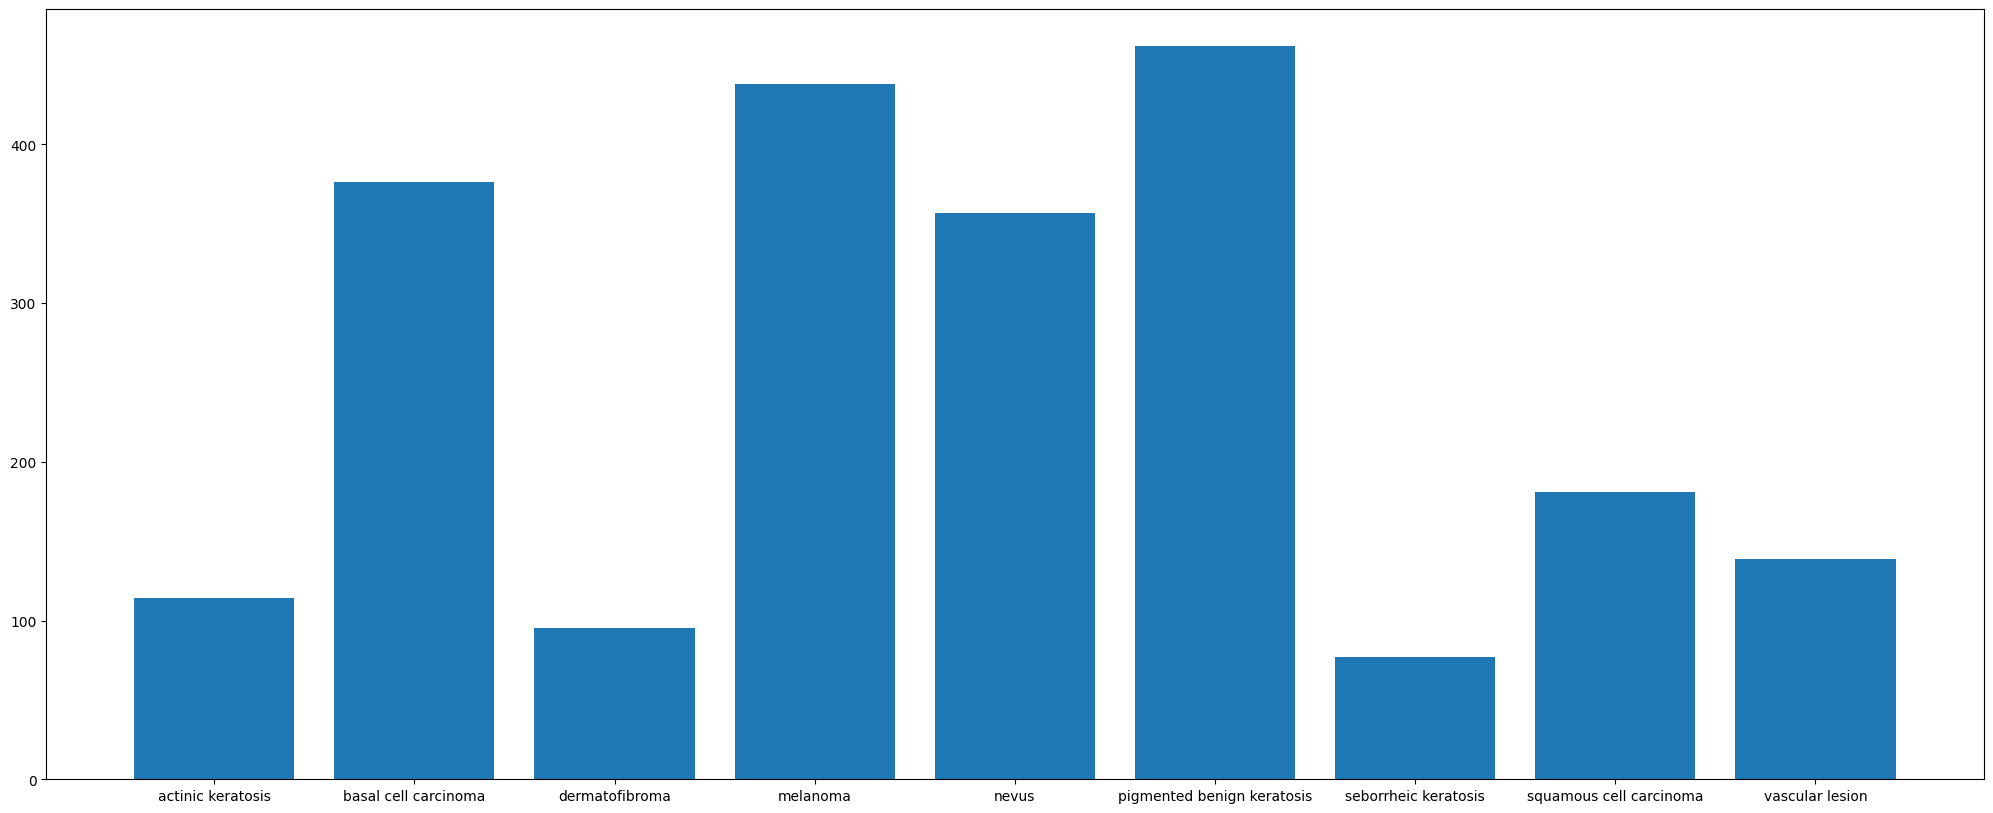

In [14]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

The above plot clearly shows that there's a class imbalance.
- `seborrheic keratosis`, `dermatofibroma`, `acitinic keratosis` have the least number of samples
- `basal cell carcinoma`, `melanoma`, `nevus` and `pigmented benign keratosis` have the highest number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [15]:
!pip3 install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [16]:
path_to_training_dataset="./Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2871043A0>: 100%|██████████| 500/500 [00:01<00:00, 492.44 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ./Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2870B87C0>: 100%|██████████| 500/500 [00:00<00:00, 503.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28716DA30>: 100%|██████████| 500/500 [00:01<00:00, 483.73 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ./Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x283BC6100>: 100%|██████████| 500/500 [00:04<00:00, 104.70 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to ./Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28556E160>: 100%|██████████| 500/500 [00:05<00:00, 95.02 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to ./Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x285565640>: 100%|██████████| 500/500 [00:01<00:00, 456.39 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17326AA90>: 100%|██████████| 500/500 [00:02<00:00, 190.21 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ./Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x287114D00>: 100%|██████████| 500/500 [00:01<00:00, 467.68 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ./Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x283CEF430>: 100%|██████████| 500/500 [00:01<00:00, 452.16 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [17]:
data_dir_train1 = pathlib.Path("./Train/")
image_count_train1 = len(list(data_dir_train1.glob('*/output/*.jpg')))
print(image_count_train1)

4500


In [18]:
##
for i in class_names:
    for j in data_dir_train1.glob(i+'/output/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,Train/actinic keratosis/ISIC_0029460.jpg,actinic keratosis
1,Train/actinic keratosis/ISIC_0031993.jpg,actinic keratosis
2,Train/actinic keratosis/ISIC_0029500.jpg,actinic keratosis
3,Train/actinic keratosis/ISIC_0026626.jpg,actinic keratosis
4,Train/actinic keratosis/ISIC_0032135.jpg,actinic keratosis
...,...,...
6734,Train/vascular lesion/output/vascular lesion_o...,vascular lesion
6735,Train/vascular lesion/output/vascular lesion_o...,vascular lesion
6736,Train/vascular lesion/output/vascular lesion_o...,vascular lesion
6737,Train/vascular lesion/output/vascular lesion_o...,vascular lesion


### Lets see the distribution of augmented data after adding new images to the original training data.

In [19]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [20]:
batch_size = 64
img_height = 180
img_width = 180

In [21]:
import pathlib

data_dir_train1=pathlib.Path("./Train/")

In [26]:
image_count_train1 = len(list(data_dir_train1.glob('*/output/*.jpg')))
print(image_count_train1)

4500


#### **Todo:** Create a training dataset

In [27]:
data_dir_train="./Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [30]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [52]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)))   #Rescaling Layer


model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(BatchNormalization())


model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(BatchNormalization())


model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(BatchNormalization())


model.add(Dropout(0.5))


model.add(Flatten())


model.add(Dense(128,activation='relu'))

model.add(BatchNormalization())


model.add(Dropout(0.25))

model.add(Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 89, 89, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_15 (Ba  (None, 89, 89, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 43, 43, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [54]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
85/85 [==============================] - 9s 96ms/step - loss: 1.7176 - accuracy: 0.3867 - val_loss: 2.9928 - val_accuracy: 0.1151
Epoch 2/50
85/85 [==============================] - 8s 93ms/step - loss: 1.3506 - accuracy: 0.5117 - val_loss: 3.0406 - val_accuracy: 0.1151
Epoch 3/50
85/85 [==============================] - 9s 98ms/step - loss: 1.1888 - accuracy: 0.5770 - val_loss: 2.8174 - val_accuracy: 0.1396
Epoch 4/50
85/85 [==============================] - 9s 95ms/step - loss: 1.0297 - accuracy: 0.6337 - val_loss: 2.2251 - val_accuracy: 0.1975
Epoch 5/50
85/85 [==============================] - 9s 96ms/step - loss: 0.9638 - accuracy: 0.6563 - val_loss: 2.8137 - val_accuracy: 0.2665
Epoch 6/50
85/85 [==============================] - 9s 99ms/step - loss: 0.8604 - accuracy: 0.6994 - val_loss: 2.0378 - val_accuracy: 0.4254
Epoch 7/50
85/85 [==============================] - 9s 99ms/step - loss: 0.7881 - accuracy: 0.7277 - val_loss: 1.6745 - val_accuracy: 0.4217
Epoch 8/50
85

#### **Todo:**  Visualize the model results

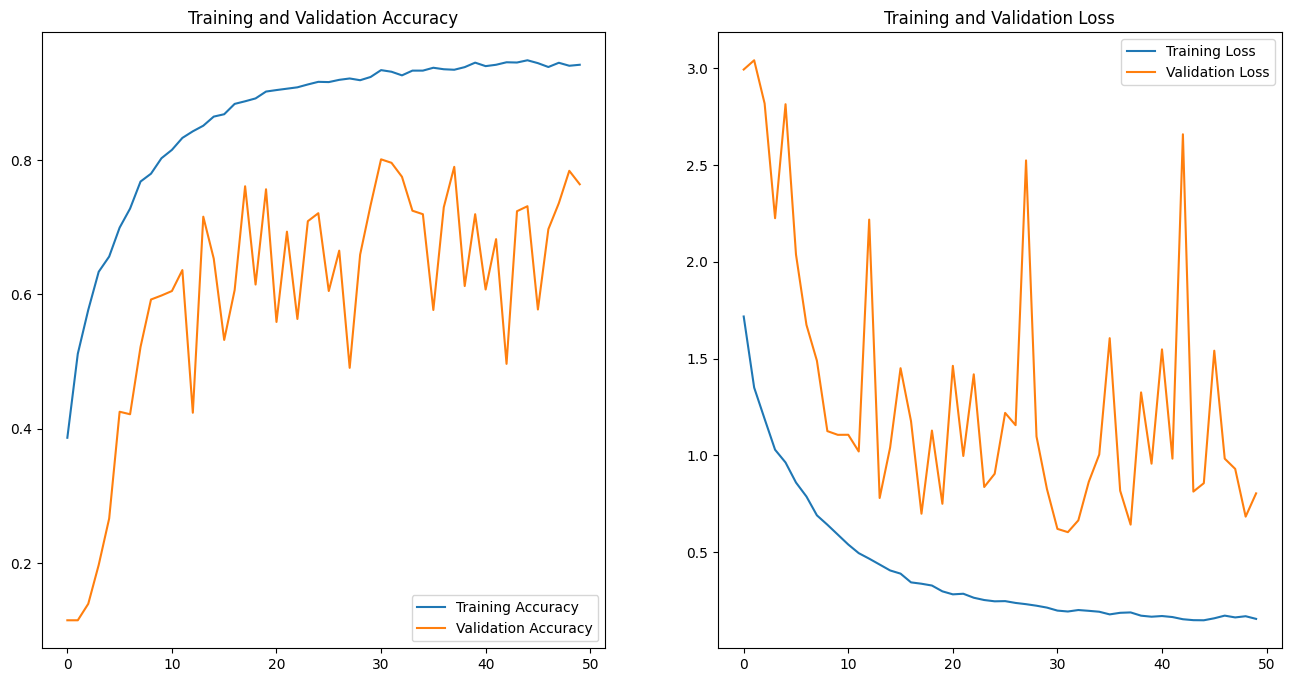

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Rebalancing the classes helped the model at some level in reducing overfitting and underfitting.
* Training loss gradually decreases as expected while we see some fluctuations in the validation loss.
* Making the model more complex or training for more epochs may get better results.

1/1 [==============================] - 0s 31ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


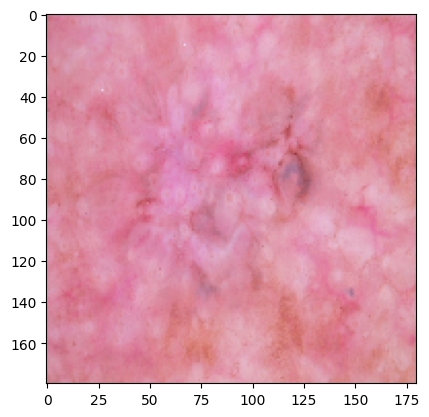

In [60]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[0], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )